# Unsupervised Representation Learning With Deep Convolutional Generative Adversial Networks
* [paper](https://arxiv.org/pdf/1511.06434v2.pdf)

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim

import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader, Subset, Dataset

from tqdm import tqdm
from typing import List,Tuple


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Network

## Useful Submodules

In [ ]:
# experimented with how i created network to have more flexibility based on 
# what i've seen with other code

class DownsampleBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int=5, 
                 stride: int=2, padding: int=2):
        super().__init__()
        self.use_batchnorm = True
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                              padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(.2)

    def forward(self, X):
        out = self.conv(X)
        if self.use_batchnorm:
            out = self.bn(out)
        out = self.act(out)
        return out

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, 
                 kernel_size: int=5, stride: int=2, padding: int=2,
                 out_padding: int=1):
        super().__init__()
        self.use_batchnorm = True
        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                        stride, padding, out_padding)
        self.bn = nn.BatchNorm2d(out_channels)
        # self.act = nn.ReLU()
        self.act = nn.LeakyReLU(.2)

    def forward(self, X):
        out = self.convT(X)
        if self.use_batchnorm:
            out = self.bn(out)
        out = self.act(out)
        return out

## Generator Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, channel_sizes: List[int], img_size: int=64, 
                 z_dim: int=100):
        super().__init__()
        num_samples = len(channel_sizes)-1
        self.z_dim = z_dim
        # dimensions of input volume for upsampling network
        # every time downsample, img_size halves
        self.in_dim = img_size//(2**num_samples)
        # depth of input volume for upsamling network
        self.in_channels = channel_sizes[0]
        # size of input volume to upsampling network flattend
        flat_size = channel_sizes[0] * self.in_dim * self.in_dim
        up_layers = []
        for i in range(num_samples):
            up_layers.append(UpsampleBlock(channel_sizes[i],
                                           channel_sizes[i+1]))
        self.img_size = img_size
        # final layer no batchnorm and use Tanh activation
        up_layers[-1].use_batchnorm = False
        up_layers[-1].act = nn.Tanh()
        self.upsample = nn.Sequential(*up_layers)
        self.fc = nn.Sequential(
            nn.Linear(z_dim, flat_size),
            nn.ReLU()
        )

    def forward(self, z: torch.Tensor):
        out = self.fc(z)
        out = out.view(-1, self.in_channels, self.in_dim, self.in_dim)
        out = self.upsample(out)
        return out
    
    def train_model(self, dis: nn.Module, bs: int, loss: nn.Module,
                    opt: torch.optim.Optimizer):
        opt.zero_grad()
        z = torch.randn((bs, self.z_dim)).to(DEVICE)
        gen_z = self(z)
        dis_z = dis(gen_z)
        # dis_z = dis(gen_z).detach()
        loss_gen = loss(dis_z, torch.full_like(dis_z, 0.9))
        loss_gen.backward()
        opt.step()
        return loss_gen


## Discriminator Network

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channel_sizes: List[int], img_size: int=64, 
                 z_dim: int=100):
        super().__init__()
        self.z_dim = z_dim
        num_samples = len(channel_sizes)-1
        # dimensions of output volume from downsampling network
        # everytime downsample, img_size halves
        out_dim = img_size//(2**num_samples)
        # depth of output volume from downsampling network
        out_channels = channel_sizes[-1]
        # size of output volume from downsampling network flattend
        flat_size = out_channels * out_dim * out_dim
        down_layers = []
        for i in range(num_samples):
            down_layers.append(DownsampleBlock(channel_sizes[i],
                                               channel_sizes[i+1]))
        # no batchnorm on input layer
        down_layers[0].use_batchnorm = False
        self.downsample = nn.Sequential(*down_layers)
        self.fc = nn.Sequential(
            nn.Linear(flat_size, 1),
            nn.Sigmoid()
        )

    def forward(self, X: torch.Tensor):
        out = self.downsample(X)
        out = torch.flatten(out, 1, 3)
        out = self.fc(out)
        return out

    def train_model(self, gen: nn.Module, batch: torch.Tensor, loss: nn.Module,
                    opt: torch.optim.Optimizer):
        opt.zero_grad()
        z = torch.randn((batch.shape[0], self.z_dim)).to(DEVICE)
        gen_z = gen(z).detach()
        dis_z = self(gen_z)
        loss_fake = loss(dis_z, torch.full_like(dis_z, 0.1))
        dis_x = self(batch)
        loss_real = loss(dis_x, torch.full_like(dis_x, 0.9))
        
        loss_total = loss_fake + loss_real
        loss_total.backward()
        opt.step()
        
        return  loss_fake, loss_real


## GAN

In [33]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [62]:
class GAN:
    def __init__(self, channel_sizes: List[int], img_size: int=64,
                 z_dim: int=100, device: str='cuda'):
        super().__init__()
        self.img_size = img_size
        self.img_channels = channel_sizes[0]
        self.gen = Generator(channel_sizes[::-1], img_size, z_dim).to(device)
        self.dis = Discriminator(channel_sizes, img_size, z_dim).to(device)
        self.d_loss_real = []
        self.d_loss_fake = []
        self.g_loss = []
        
    def train_model(self, ds: Dataset, fixed: torch.Tensor, epochs: int, 
                    bs: int=64, lr: float=1e-3, beta_1: float=.5, beta_2=.999, 
                    z_dim: int=100, train_ratio: Tuple[int,int]=(1,2)):
        dl = DataLoader(ds, batch_size=bs, shuffle=True)
        opt_gen = optim.Adam(self.gen.parameters(), betas=(beta_1, beta_1), 
                             lr=lr)
        opt_dis = optim.Adam(self.dis.parameters(), betas=(beta_1, beta_2), 
                             lr=lr)
        
        bce = nn.BCELoss()
        d_train_num = train_ratio[0]
        g_train_num = train_ratio[1]

        for i in tqdm(range(epochs)):
            self.gen.train()
            self.dis.train()
            for j, (X,_) in enumerate(dl):
                X = X.to(DEVICE)
                batch_size = X.shape[0]
                # train discriminator
                for _ in range(d_train_num):
                    losses = self.dis.train_model(self.gen, X, bce, opt_dis)
                    loss_dis_fake, loss_dis_real = losses
                    self.d_loss_fake.append(loss_dis_fake.detach().cpu())
                    self.d_loss_real.append(loss_dis_real.detach().cpu())
                # train generator
                for _ in range(g_train_num):
                    loss_gen = self.gen.train_model(self.dis, X.shape[0], bce,
                                                    opt_gen)
                    self.g_loss.append(loss_gen.detach().cpu())
            if i % 5 == 0 or i == epochs-1:
                self.gen.eval()
                out = self.gen(fixed).detach().cpu()
                img = T.ToPILImage()(out.view(self.img_channels, self.img_size,
                                              self.img_size))
                display(img)

# Getting Data

In [ ]:
train = None

dataset = 'fgvc-aircraft'

In [4]:
if dataset == 'fgvc-aircraft':
    # FGVC-Aircraft Dataset
    img_size = (64, 64)
    ts = [T.ToTensor(), T.Resize(img_size)]

    train = datasets.FGVCAircraft(
        root='data',
        split='train',
        download=True,
        transform=T.Compose(ts) 
    )

if dataset == 'mnist':
    # MNIST Dataset
    ...


  0%|          | 0/2753340328 [00:00<?, ?it/s]

Extracting data/fgvc-aircraft-2013b.tar.gz to data


# Training

In [63]:
channel_sizes = [3, 128, 256, 512, 1024]

data = train
subset_size = 500
use_subset = True
if use_subset:
    data = Subset(train, range(subset_size))

In [54]:
EPOCHS = 20
BS = 64
BETA_1 = 0.5
BETA_2 = 0.999
LR = 1e-4
Z_DIM = 100

In [60]:
fixed = torch.randn([1, Z_DIM]).to(DEVICE)

In [ ]:
gan = GAN(channel_sizes)

  0%|          | 0/20 [00:00<?, ?it/s]

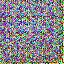

 25%|██▌       | 5/20 [01:41<05:06, 20.46s/it]

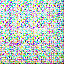

 50%|█████     | 10/20 [03:19<03:16, 19.70s/it]

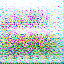

 75%|███████▌  | 15/20 [04:54<01:35, 19.20s/it]

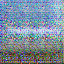

 95%|█████████▌| 19/20 [06:17<00:20, 20.20s/it]

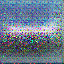

100%|██████████| 20/20 [06:37<00:00, 19.88s/it]


In [64]:
gan.train_model(
    ds=data,
    fixed=fixed,
    epochs=EPOCHS,
    bs=BS,
    lr=LR,
    beta_1=BETA_1,
    beta_2=BETA_2,
    z_dim=Z_DIM
)

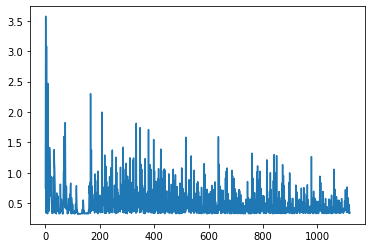

In [28]:
plt.plot(gan.d_loss_real)

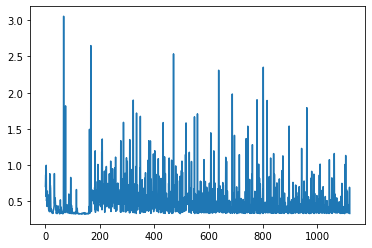

In [27]:
plt.plot(gan.d_loss_fake)

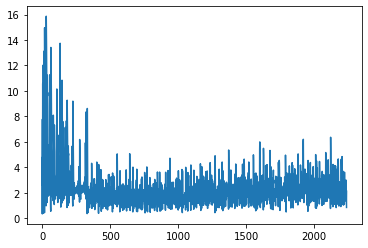

In [26]:
plt.plot(gan.g_loss)

# Testing

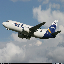

real 0.3388707102276385
gen tensor(0.3542, device='cuda:0')


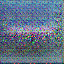

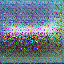

In [65]:
to_img = T.ToPILImage()

real_img = to_img(train[100][0])
display(real_img)

gan.gen.eval()
gan.dis.eval()

out = gan.gen(torch.randn((64, 100)).to(DEVICE)).detach()

mean = 0
for i in Subset(train, range(64)):
    a = gan.dis(i[0].view(-1, 3, 64, 64).to(DEVICE)).detach().item()
    mean += a
    
mean /= 64
print('real', mean)
print('gen', gan.dis(out).detach().view(64).mean())
gen_img = to_img(out[0].view(-1, 64, 64))
display(gen_img)
# dis(out)

out = gan.gen(fixed.to(DEVICE)).detach()
gen_img = to_img(out.view(-1, 64, 64))
display(gen_img)